<div style="text-align:right">Justine Charrel - Master 2 Internship</div>
This script plot the maps (60°S-90°S) of low, mid, high and total cloud cover for CALIPSO-GOCCP, for LMDZ6A and for their difference.

### IMPORT

In [22]:
import netCDF4
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

### READ DATA

In [23]:
# CALIPSO-GOCCP
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/CALIPSO/'
ncfile_obs=path+"CALIPSO_2DCloudCover_climato_2008-2021_except_2016_CFMIP2_sat_3.1.4_r144x90.nc"
nc_obs = netCDF4.Dataset(ncfile_obs)

In [24]:
# MASK
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/LMDZ6A/'
ncfile_mask=path+"LmdzOr6Actrl_SE_1980_1999_1M_histmth_phis_r144x90.nc"
nc_mask = netCDF4.Dataset(ncfile_mask)

In [25]:
# LMDZ6A
path = '/home/jcharrel/Documents/M2_Internship_LMD/data/LMDZ6A/'
ncfile_lmdz6a=path+'LmdzOr6Actrl_calipso_r144x90.nc'
nc_lmdz6a = netCDF4.Dataset(ncfile_lmdz6a)

In [26]:
# GRID
lon = nc_obs.variables['lon'][:]
lat = nc_obs.variables['lat'][:]

lat_id = (lat <= -60) 
lat = lat[lat_id]

# Circle plot for polar projection
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

### LOAD VARIABLES

In [27]:
# CALIPSO-GOCCP
cllobs = nc_obs.variables['cllcalipso'][0,lat_id,:]
clmobs = nc_obs.variables['clmcalipso'][0,lat_id,:]
clhobs = nc_obs.variables['clhcalipso'][0,lat_id,:]
cltobs = nc_obs.variables['cltcalipso'][0,lat_id,:]
obs = np.dstack((cllobs,clmobs,clhobs,cltobs))

# LMDZ6A
clllmdz6a = nc_lmdz6a.variables['cllcalipso'][0,lat_id,:]
clmlmdz6a = nc_lmdz6a.variables['clmcalipso'][0,lat_id,:]
clhlmdz6a = nc_lmdz6a.variables['clhcalipso'][0,lat_id,:]
cltlmdz6a = nc_lmdz6a.variables['cltcalipso'][0,lat_id,:]

# Outliers values
clllmdz6a[clllmdz6a>1e5] = np.nan
clmlmdz6a[clmlmdz6a>1e5] = np.nan
clhlmdz6a[clhlmdz6a>1e5] = np.nan
cltlmdz6a[cltlmdz6a>1e5] = np.nan

lmdz6a = np.dstack((clllmdz6a,clmlmdz6a,clhlmdz6a,cltlmdz6a))

# DIFFERENCE
clldiff = clllmdz6a-cllobs
clmdiff = clmlmdz6a-clmobs
clhdiff = clhlmdz6a-clhobs
cltdiff = cltlmdz6a-cltobs
diff = np.ma.dstack((clldiff, clmdiff, clhdiff, cltdiff))

total = np.ma.dstack((obs,lmdz6a,diff))

# ALTITUDE
g = 9.81 # m/s
alt = nc_mask.variables['phis'][0,lat_id,:]/g #m

### FUNCTION PLOT

In [28]:
def plot(titles,texts,labels,language) :
    fig, axes = plt.subplots(figsize=(16,9), nrows=3, ncols=4, subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
    
    fig.text(0.04, 0.82, texts[0], fontsize=16, va='center', ha='center', rotation='vertical')
    fig.text(0.04, 0.5, texts[1], fontsize=16, va='center', ha='center', rotation='vertical')
    fig.text(0.03, 0.17, texts[2], fontsize=16, va='center', ha='center', rotation='vertical')
    
    alphabet = 'abcdefghijklmnopqrstuvwxyz'
    pltcounter = 0
    for idx,plotid in enumerate(axes.flat):
        pltcounter = pltcounter + 1
        if pltcounter == 1:
            plotid.set_title(titles[0], fontsize=16)
        elif pltcounter == 2:
            plotid.set_title(titles[1], fontsize=16)
        elif pltcounter == 3:
            plotid.set_title(titles[2], fontsize=16)
        elif pltcounter == 4:
            plotid.set_title(titles[3], fontsize=16)
    
        clplot = total[:,:,pltcounter-1]*100
        clplt, lonplt = add_cyclic_point(clplot, coord=lon) #filling the gap at longitude 0
    
        plotid.set_extent([-180, 180, np.min(lat), np.max(lat)], ccrs.PlateCarree())
        plotid.set_boundary(map_circle, transform=plotid.transAxes)
        
        if pltcounter <= 8 :
            clevs1 = np.array([0,1,2,4,6,8,10,15,20,30,40,50,60,70,80,90,100])
            norm = mpl.colors.BoundaryNorm(boundaries=clevs1, ncolors=256)
            cmap = 'jet'
            cs1 = plotid.contourf(lonplt, lat, clplt, clevs1, transform=ccrs.PlateCarree(), norm = norm, cmap=cmap)
        else :
            clevs2 = np.arange(-0.4,0.45,0.05)*100
            cmap='seismic'
            cs2 = plotid.contourf(lonplt, lat, clplt,  clevs2, transform=ccrs.PlateCarree(), norm = None, cmap=cmap)
        
        plotid.coastlines(resolution="110m",linewidth=1)
        alt_contours = plotid.contour(lon, lat, alt, colors='black', linestyles=':', levels=[1000,2000,3000,4000], linewidths=0.5,  transform=ccrs.PlateCarree())
        plotid.clabel(alt_contours, inline=True, fontsize=8, fmt='%1.0f m') #add altitudes labels
        plotid.annotate(f'({alphabet[idx]})', xy=(0.02, 0.95), xycoords='axes fraction', color='darkgrey', fontsize=15, weight='bold', ha='left', va='top')
        
    fig.tight_layout()
    fig.subplots_adjust(right=0.8, left=0.05, wspace=0.1)
    
    line = plt.Line2D([0.05, 0.8], [0.98/3, 0.98/3], color='black', linestyle='--', linewidth=2, transform=fig.transFigure)
    fig.add_artist(line)
    
    cbar_ax1 = fig.add_axes([0.84, 0.35, 0.008, 0.6])
    cbar_ax2 = fig.add_axes([0.84, 0.01, 0.008, 0.32])
    cb1 = fig.colorbar(cs1, cax=cbar_ax1, ticks=clevs1)
    cb2 = fig.colorbar(cs2, cax=cbar_ax2, ticks=clevs2)
    cb1.ax.tick_params(labelsize=12)
    cb2.ax.tick_params(labelsize=12)
    cb1.set_label(labels[0], fontsize=14)
    cb2.set_label(labels[1], fontsize=14)
    
    path_fig = '/home/jcharrel/Documents/M2_Internship_LMD/figures/2DCloudCover/maps/climato/'
    plt.savefig(path_fig+'2DCloudCover_maps_climato_'+language+'.png',dpi=300, bbox_inches='tight')

### PLOT FIGURE (FR)

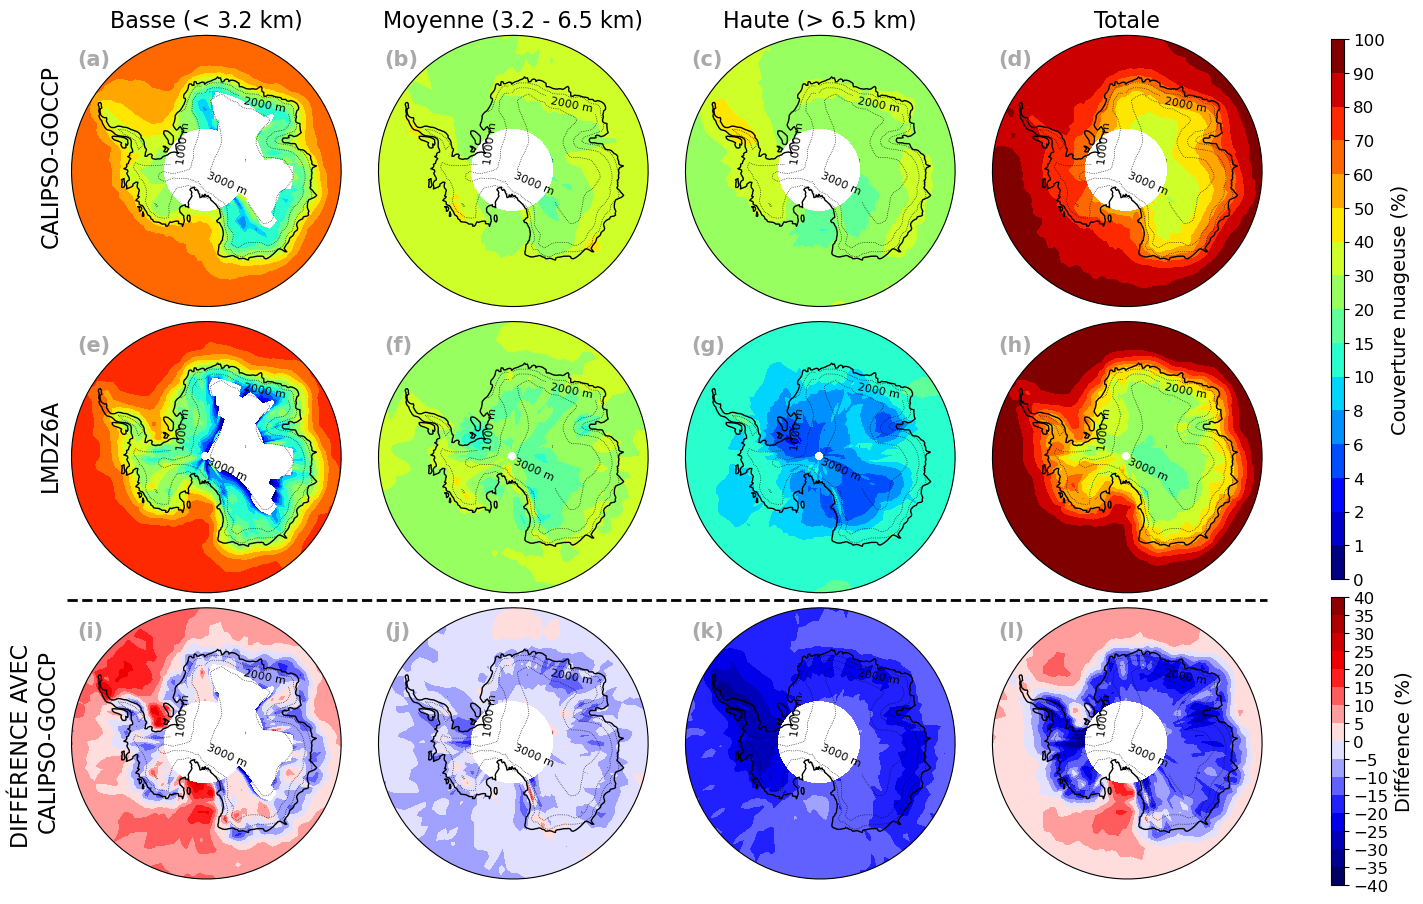

In [29]:
titles = ["Basse (< 3.2 km)","Moyenne (3.2 - 6.5 km)","Haute (> 6.5 km)","Totale"]
texts = ['CALIPSO-GOCCP','LMDZ6A','DIFFÉRENCE AVEC \nCALIPSO-GOCCP']
labels = ['Couverture nuageuse (%)','Différence (%)']
language = 'FR'
plot(titles,texts,labels, language)

### PLOT FIGURE (EN)

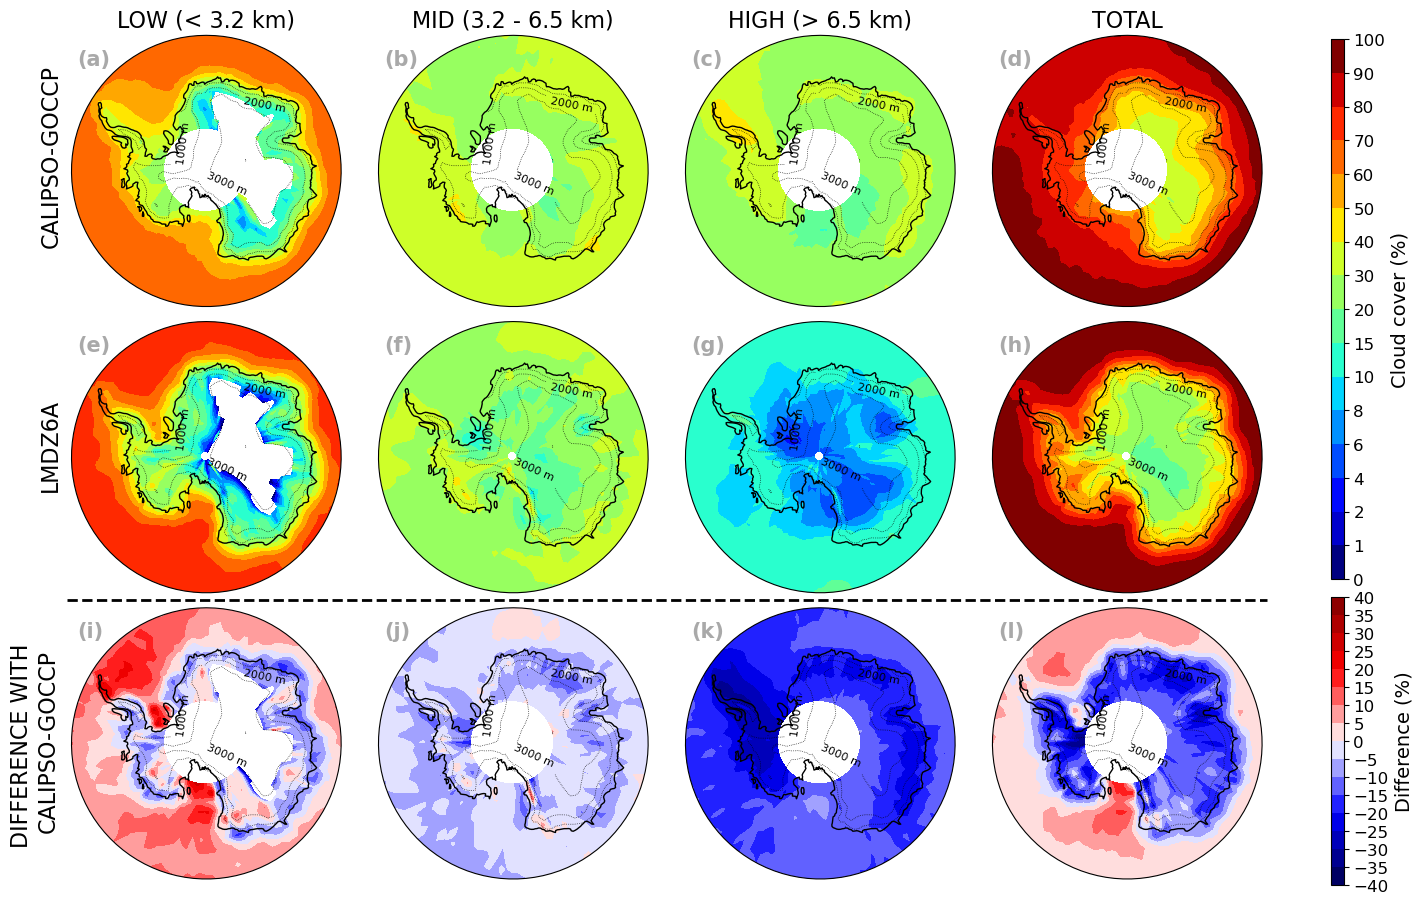

In [30]:
titles = ["LOW (< 3.2 km)","MID (3.2 - 6.5 km)","HIGH (> 6.5 km)","TOTAL"]
texts = ['CALIPSO-GOCCP','LMDZ6A','DIFFERENCE WITH \nCALIPSO-GOCCP']
labels = ['Cloud cover (%)','Difference (%)']
language = 'EN'
plot(titles,texts,labels, language)